#0. Import libraries

In [17]:
import os
import zipfile
import numpy as np
import cv2
import pickle
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive


#1. Mount Drive and Extract Dataset

In [18]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Vision_adv/archive.zip'
extract_path = '/content/socofing'
if not os.path.exists(os.path.join(extract_path, 'SOCOFing')):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

real_dir = '/content/socofing/SOCOFing/Real'
all_files = [f for f in os.listdir(real_dir) if f.endswith('.BMP')]
identities = sorted(list(set([f.split('__')[0] for f in all_files])))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#2. Load and Prepare Images

In [47]:
selected_ids = identities[:10]
label_map = {name: idx for idx, name in enumerate(selected_ids)}

def load_images():
    X, y = [], []
    for file in all_files:
        person = file.split('__')[0]
        if person in selected_ids:
            img = cv2.imread(os.path.join(real_dir, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (96, 96))
            X.append(img)
            y.append(label_map[person])
    X = np.array(X) / 255.0
    X = np.expand_dims(X, -1)
    y = np.array(y)
    return X, y

X, y = load_images()

#3. Create Training Pairs

In [48]:
def create_pairs(X, y):
    pairs, labels = [], []
    class_idx = {i: np.where(y == i)[0] for i in range(len(selected_ids))}
    for i in range(len(X)):
        x1 = X[i]
        y1 = y[i]
        j = i
        while j == i:
            j = np.random.choice(class_idx[y1])
        x2 = X[j]
        pairs.append([x1, x2])
        labels.append(1)

        y2 = np.random.choice([l for l in range(len(selected_ids)) if l != y1])
        j = np.random.choice(class_idx[y2])
        x2 = X[j]
        pairs.append([x1, x2])
        labels.append(0)

    return np.array(pairs), np.array(labels)

pairs, pair_labels = create_pairs(X, y)
X1 = pairs[:, 0]
X2 = pairs[:, 1]
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, pair_labels, test_size=0.2, random_state=42)


#4. Siamese Model Definition

In [63]:
def get_base_model():
    base = ResNet50V2(include_top=False, weights='imagenet', input_shape=(96, 96, 3), pooling='avg')
    for layer in base.layers[:-10]:
        layer.trainable = False
    input_layer = Input(shape=(96, 96, 1))
    x = Concatenate()([input_layer, input_layer, input_layer])
    x = base(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_layer, x)

def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def build_siamese():
    base_model = get_base_model()
    input_a = Input(shape=(96, 96, 1))
    input_b = Input(shape=(96, 96, 1))
    emb_a = base_model(input_a)
    emb_b = base_model(input_b)
    distance = Lambda(euclidean_distance)([emb_a, emb_b])
    siamese = Model(inputs=[input_a, input_b], outputs=distance)
    siamese.compile(loss=contrastive_loss, optimizer=Adam(0.0001), metrics=['accuracy'])
    return siamese

siamese_model = build_siamese()

#5. Train the Model

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = siamese_model.fit([X1_train, X2_train], y_train,
                             validation_data=([X1_test, X2_test], y_test),
                             batch_size=32, epochs=20, callbacks=[early_stop])

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4847 - loss: 14.5286 - val_accuracy: 0.6000 - val_loss: 85.9423
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.4856 - loss: 3.8461 - val_accuracy: 0.6000 - val_loss: 49.8571
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4665 - loss: 1.0703 - val_accuracy: 0.6000 - val_loss: 29.0937
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4617 - loss: 0.4415 - val_accuracy: 0.6000 - val_loss: 17.2703
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4878 - loss: 0.3045 - val_accuracy: 0.6000 - val_loss: 10.4853
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2924 - loss: 0.1830 - val_accuracy: 0.6000 - val_loss: 6.7011
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.1595 - loss: 0.1521 - val_accuracy: 0.6000 - val_loss: 4.5347
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1453 - loss: 0.1460 - val_accuracy: 0.6000 - val_loss:


#6. Evaluation and Plotting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6354 - loss: 0.7285
Test Accuracy: 0.625


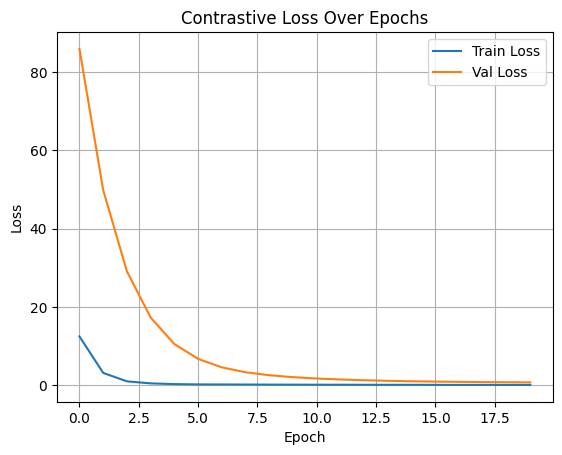

In [65]:
test_loss, test_acc = siamese_model.evaluate([X1_test, X2_test], y_test)
print("Test Accuracy:", test_acc)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#7. User Registration and Identification

In [69]:
USER_DB_PATH = '/content/users.pkl'

def preprocess(img):
    img = cv2.resize(img, (96, 96))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=[0, -1])
    return img

def register_new_user(user_id, fingerprint_images):
    if len(fingerprint_images) < 5:
        print("Error: Please provide at least 5 fingerprint images.")
        return

    base_model = siamese_model.layers[2]
    embeddings = []
    for img in fingerprint_images[:5]:
        if img is None:
            continue
        img_processed = preprocess(img)
        emb = base_model.predict(np.expand_dims(img_processed, axis=0))[0]
        embeddings.append(emb)

    if os.path.exists(USER_DB_PATH):
        with open(USER_DB_PATH, 'rb') as f:
            all_users = pickle.load(f)
    else:
        all_users = []

    all_users.append({'user_id': user_id, 'embeddings': embeddings})

    with open(USER_DB_PATH, 'wb') as f:
        pickle.dump(all_users, f)

    print(f"User '{user_id}' registered successfully with {len(embeddings)} fingerprints.")

def identify_user(fingerprint_img, threshold=0.5):
    if not os.path.exists(USER_DB_PATH):
        print("No registered users found. Please register users first.")
        return "Unknown"

    if fingerprint_img is None:
        print("Invalid input image.")
        return "Unknown"

    with open(USER_DB_PATH, 'rb') as f:
        all_users = pickle.load(f)

    img = preprocess(fingerprint_img)
    base_model = siamese_model.layers[2]
    query_emb = base_model.predict(np.expand_dims(img, axis=0))[0]

    min_dist = float('inf')
    matched_user = "Unknown"
    for user in all_users:
        for emb in user['embeddings']:
            dist = np.linalg.norm(query_emb - emb)
            if dist < min_dist:
                min_dist = dist
                matched_user = user['user_id']

    print(f"Closest match: {matched_user}, Distance: {min_dist:.4f}")
    return matched_user if min_dist < threshold else "Unknown"

#8. Register a Sample User

In [70]:
paths_to_5_images = ['/content/finger1.bmp', '/content/finger2.bmp', '/content/finger3.bmp', '/content/finger4.bmp', '/content/finger5.bmp']
new_fingerprints = [cv2.imread(p, 0) for p in paths_to_5_images]
register_new_user('user123', new_fingerprints)

User 'user123' registered successfully with 0 fingerprints.



#9. Identify a User From a Fingerprint

In [73]:
test_img = cv2.imread('/content/test_fingerprint.bmp', 0)
identify_user(test_img)

No registered users found. Please register users first.


'Unknown'